- LSTM은 RNN(Recurrent Neural Network) 알고리즘의 특별한 한 종류입니다.
- RNN은 글, 유전자, 손글씨, 음성 신호, 주가 등 배열(sequence 또는 시계열 데이터)의 형태를 갖는 데이터에서 패턴을 인식하는 인공 신경망입니다.
- LSTM은 기존 RNN을 개선한 모델로 긴 의존 기간(long-term dependency)을 필요로 하는 데이터를 학습하는데 효과적인 모델입니다.

In [ ]:
!df -h # 하드디스크 확인

In [ ]:
!cat /proc/meminfo # 메모리 체크

In [ ]:
!cat /proc/cpuinfo # cpu 정보

In [5]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# 파일 업로드 기능 실행 
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving 교량_기준_임시_최종db.csv to 교량_기준_임시_최종db.csv
User uploaded file "교량_기준_임시_최종db.csv" with length 672898034 bytes


In [8]:
df = pd.read_csv('/content/교량_기준_임시_최종db.csv')
df

,Unnamed: 0,Unnamed: 0.1,bridge_name,address,etc_address,latitude,longitude,brid_height_origin,location_start,wl_station_code,rf_station_code,obs_date,WL,rainfall,bridge_height
0,0,0,신원교,경기도,이천시,37.291282,127.509880,5.4,"[37.291282, 127.50988000000001]",1007645,10074060,2010-02-25 12:00:00,3.0,0.0,510.0
1,1,1,신원교,경기도,이천시,37.291282,127.509880,5.4,"[37.291282, 127.50988000000001]",1007645,10074060,2010-02-25 13:00:00,6.0,0.0,510.0
2,2,2,신원교,경기도,이천시,37.291282,127.509880,5.4,"[37.291282, 127.50988000000001]",1007645,10074060,2010-02-25 14:00:00,10.0,0.0,510.0
3,3,3,신원교,경기도,이천시,37.291282,127.509880,5.4,"[37.291282, 127.50988000000001]",1007645,10074060,2010-02-25 15:00:00,14.0,0.0,510.0
4,4,4,신원교,경기도,이천시,37.291282,127.509880,5.4,"[37.291282, 127.50988000000001]",1007645,10074060,2010-02-25 16:00:00,18.0,0.0,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4097827,4097827,4381107,대곡교,서울특별시,강남구,37.468243,127.121565,3.0,"[37.468243, 127.12156499999999]",1018655,10184100,2017-06-26 17:00:00,184.0,0.0,483.0
4097828,4097828,4381108,대곡교,서울특별시,강남구,37.468243,127.121565,3.0,"[37.468243, 127.12156499999999]",1018655,10184100,2017-06-26 18:00:00,184.0,0.0,483.0
4097829,4097829,4381109,대곡교,서울특별시,강남구,37.468243,127.121565,3.0,"[37.468243, 127.12156499999999]",1018655,10184100,2017-06-26 19:00:00,185.0,0.0,483.0
4097830,4097830,4381110,대곡교,서울특별시,강남구,37.468243,127.121565,3.0,"[37.468243, 127.12156499999999]",1018655,10184100,2017-06-26 20:00:00,185.0,0.0,483.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097832 entries, 0 to 4097831
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   Unnamed: 0.1        int64  
 2   bridge_name         object 
 3   address             object 
 4   etc_address         object 
 5   latitude            float64
 6   longitude           float64
 7   brid_height_origin  float64
 8   location_start      object 
 9   wl_station_code     int64  
 10  rf_station_code     int64  
 11  obs_date            object 
 12  WL                  float64
 13  rainfall            float64
 14  bridge_height       float64
dtypes: float64(6), int64(4), object(5)
memory usage: 469.0+ MB


In [14]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0.1', axis=1)
df = df.drop('wl_station_code', axis=1)
df = df.drop('rf_station_code', axis=1)
df = df.drop('rainfall', axis=1)

In [18]:
df, df.info() # df 컬럼 인덱스 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097832 entries, 0 to 4097831
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   bridge_name         object 
 1   address             object 
 2   etc_address         object 
 3   latitude            float64
 4   longitude           float64
 5   brid_height_origin  float64
 6   location_start      object 
 7   obs_date            object 
 8   WL                  float64
 9   bridge_height       float64
dtypes: float64(5), object(5)
memory usage: 312.6+ MB


(        bridge_name address  ...     WL  bridge_height
 0               신원교     경기도  ...    3.0          510.0
 1               신원교     경기도  ...    6.0          510.0
 2               신원교     경기도  ...   10.0          510.0
 3               신원교     경기도  ...   14.0          510.0
 4               신원교     경기도  ...   18.0          510.0
 ...             ...     ...  ...    ...            ...
 4097827         대곡교   서울특별시  ...  184.0          483.0
 4097828         대곡교   서울특별시  ...  184.0          483.0
 4097829         대곡교   서울특별시  ...  185.0          483.0
 4097830         대곡교   서울특별시  ...  185.0          483.0
 4097831         대곡교   서울특별시  ...  185.0          483.0
 
 [4097832 rows x 10 columns], None)

In [112]:
bridge_list = pd.unique(df['bridge_name']).tolist() # 교량 리스트
len(bridge_list)

49

In [123]:
# 49개 교량 dataframe 한 번에 어떻게 만들지..
lstm_brid_df = {}
for i in range(len(bridge_list)):
  lstm_brid_df = df[df['bridge_name']==bridge_list[i]].iloc[:-1, [7,8]]
  # df[df['bridge_name']==bridge_list[i]]['WL'].plot()
  # plt.title(bridge_list[i])
  # plt.show()

In [124]:
lstm_brid_df

,obs_date,WL
4004514,2010-01-01 00:00:00,178.0
4004515,2010-01-01 01:00:00,178.0
4004516,2010-01-01 02:00:00,178.0
4004517,2010-01-01 03:00:00,178.0
4004518,2010-01-01 04:00:00,178.0
...,...,...
4097826,2017-06-26 16:00:00,184.0
4097827,2017-06-26 17:00:00,184.0
4097828,2017-06-26 18:00:00,184.0
4097829,2017-06-26 19:00:00,185.0


In [20]:
lstm_df = df[df['bridge_name']=='신원교'].iloc[:-1, [7, 8]] # 신원교 df for lstm
lstm_df

,obs_date,WL
0,2010-02-25 12:00:00,3.0
1,2010-02-25 13:00:00,6.0
2,2010-02-25 14:00:00,10.0
3,2010-02-25 15:00:00,14.0
4,2010-02-25 16:00:00,18.0
...,...,...
397888,2020-08-26 20:00:00,68.0
397889,2020-08-26 21:00:00,68.0
397890,2020-08-26 22:00:00,68.0
397891,2020-08-26 23:00:00,69.0


In [40]:
lstm_df = lstm_df.set_index('obs_date')
lstm_df

,WL
obs_date,
2010-02-25 12:00:00,3.0
2010-02-25 13:00:00,6.0
2010-02-25 14:00:00,10.0
2010-02-25 15:00:00,14.0
2010-02-25 16:00:00,18.0
...,...
2020-08-26 20:00:00,68.0
2020-08-26 21:00:00,68.0
2020-08-26 22:00:00,68.0


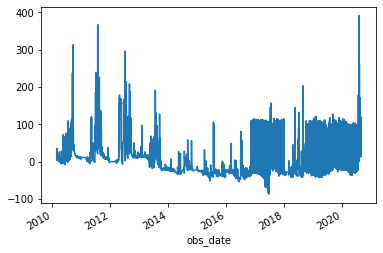

In [46]:
lstm_df['WL'].plot()

In [55]:
from sklearn.model_selection import train_test_split

split_date = '2017-01-01 00:00:00'
## X의 train, test용 데이터: 스플릿 기준으로 나누기
train = lstm_df.loc[:split_date, ['WL']]
test = lstm_df.loc[split_date:, ['WL']]
train.shape, test.shape

((54585, 1), (56586, 1))

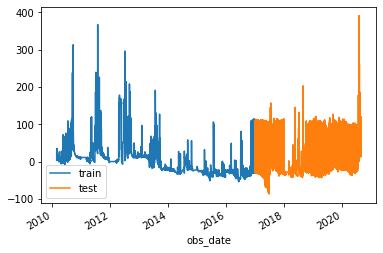

In [56]:
# train, test 데이터 시각화
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [57]:
# 데이터 스케일링(Scaling)
# 마지막으로 MinMaxScaler 클래스를 사용하여 데이터를 스케일링
# MinMaxScalar(X)는 데이터의 최대값이 1, 최소값이 0이 되도록 변환
# 데이터의 scale을 맞추면 weight의 scale도 일관성 있게 나올 수 있다.
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.13539192],
       [0.14251781],
       [0.152019  ],
       ...,
       [0.3824228 ],
       [0.3824228 ],
       [0.3824228 ]])

In [58]:
# 정규화가 완료된 데이터들은 다시 pandas dataframe 데이터 타입으로 변환
# dataframe으로 타입을 변경하는 이유는 pandas는 시계열 자료에 대한 다양한 기능을 제공하여 LSTM에서 사용하는 window를 만들기 유용하기 때문
train_sc_df = pd.DataFrame(train_sc, columns=['WL'], index=X_train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['WL'], index=X_test.index)
train_sc_df.head()

,WL
obs_date,
2010-02-25 12:00:00,0.135392
2010-02-25 13:00:00,0.142518
2010-02-25 14:00:00,0.152019
2010-02-25 15:00:00,0.161520
2010-02-25 16:00:00,0.171021


In [59]:
# sliding window 구성
# window: LSTM 훈련을 위한 고정된 사이즈 단위
# window 12개로 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값을 예측
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['WL'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['WL'].shift(s)

train_sc_df.head(13)

,WL,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
obs_date,,,,,,,,,,,,,
2010-02-25 12:00:00,0.135392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 13:00:00,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 14:00:00,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 15:00:00,0.161520,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 16:00:00,0.171021,0.161520,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 17:00:00,0.180523,0.171021,0.161520,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 18:00:00,0.187648,0.180523,0.171021,0.161520,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-25 19:00:00,0.192399,0.187648,0.180523,0.171021,0.161520,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN,NaN
2010-02-25 20:00:00,0.192399,0.192399,0.187648,0.180523,0.171021,0.161520,0.152019,0.142518,0.135392,NaN,NaN,NaN,NaN


In [60]:
# 과거 12개 하천 수위 지수들이 train 속성들이 되고, '현재 하천 수위의 지수'가 y(target)이 된다.
# 데이터에서 결측값 제거
# 전체 데이터를 train 데이터, test 데이터로 분리
# 각각의 train, test 데이터는 속성과 타겟열로 분리
X_train = train_sc_df.dropna().drop('WL', axis=1)
y_train = train_sc_df.dropna()[['WL']]

X_test = test_sc_df.dropna().drop('WL', axis=1)
y_test = test_sc_df.dropna()[['WL']]

X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
obs_date,,,,,,,,,,,,
2010-02-26 00:00:00,0.194774,0.194774,0.194774,0.192399,0.192399,0.187648,0.180523,0.171021,0.161520,0.152019,0.142518,0.135392
2010-02-26 01:00:00,0.192399,0.194774,0.194774,0.194774,0.192399,0.192399,0.187648,0.180523,0.171021,0.161520,0.152019,0.142518
2010-02-26 02:00:00,0.190024,0.192399,0.194774,0.194774,0.194774,0.192399,0.192399,0.187648,0.180523,0.171021,0.161520,0.152019
2010-02-26 03:00:00,0.187648,0.190024,0.192399,0.194774,0.194774,0.194774,0.192399,0.192399,0.187648,0.180523,0.171021,0.161520
2010-02-26 04:00:00,0.185273,0.187648,0.190024,0.192399,0.194774,0.194774,0.194774,0.192399,0.192399,0.187648,0.180523,0.171021


In [61]:
# dataframe 타입이었던 train, test 데이터들을 values로 dataframe의 numpy 표현형만 가져옴
# sklearn을 비롯해서 기계학습 패키지들은 train, test 데이터로 numpy의 ndarray 타입을 지원
# values를 사용하기 전 X_train은 DataFrame 타입, values를 사용한 후 numpy.ndarray로 변경 확인
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 
# X_train 데이터는 54573개 데이터 갯수, 12개 slot
# y_train 데이터는 54573개 데이터, 1개의 target
print(X_train.shape)
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(54573, 12)
(54573, 1)


In [62]:
# 최종 훈련 데이터 생성을 위해 keras의 LSTM에 필요한 3차원 데이터로 변환
# 최종 데이터 shape이 (size, timestamp, feature) 형태로 나타나야함.
# 속성이 하천 수위 지수 한가지이므로 1을 입력, n 개의 속성을 사용할 경우 feature 순서에 n의 값을 입력
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(54573, 12, 1)
[[[0.19477435]
  [0.19477435]
  [0.19477435]
  ...
  [0.152019  ]
  [0.14251781]
  [0.13539192]]

 [[0.19239905]
  [0.19477435]
  [0.19477435]
  ...
  [0.16152019]
  [0.152019  ]
  [0.14251781]]

 [[0.19002375]
  [0.19239905]
  [0.19477435]
  ...
  [0.17102138]
  [0.16152019]
  [0.152019  ]]

 ...

 [[0.3824228 ]
  [0.3824228 ]
  [0.3824228 ]
  ...
  [0.3824228 ]
  [0.3824228 ]
  [0.3824228 ]]

 [[0.3824228 ]
  [0.3824228 ]
  [0.3824228 ]
  ...
  [0.3824228 ]
  [0.3824228 ]
  [0.3824228 ]]

 [[0.3824228 ]
  [0.3824228 ]
  [0.3824228 ]
  ...
  [0.3824228 ]
  [0.3824228 ]
  [0.3824228 ]]]
[[0.19239905]
 [0.19002375]
 [0.18764846]
 ...
 [0.3824228 ]
 [0.3824228 ]
 [0.3824228 ]]


In [104]:
# LSTM 모델의 입력은 기본적으로 3차원 구조(최종 훈련 데이터를 생성하기 위해 3차원 데이터로 변환 필수)
# 첫 번째 차원: 데이터(sample/batch) 갯수, 두번째 차원: 시간축의 차원(time step size),
# 마지막 차원: LSTM 입력층에 입력되는 데이터(feature) 갯수
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# 모델 생성전에 tensorflow의 graph 영역을 clear한다.
K.clear_session()

# Sequeatial Model: 레이어들을 선형으로 쌓는 모델
model = Sequential() 
# LSTM 레이어: 20메모리 셀, (timestep, feature)
model.add(LSTM(20, input_shape=(1, 1))) 
# Dense 레이어: output = 1(예측하고자 하는 target갯수)
model.add(Dense(1)) 
# optimizer: 훈련과정 설정, loss: 최적화 과정에서 최소화될 손실 함수 설정, metrics: 훈련 모니터링위해 사용
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) # metrics = ['accuracy']는 classification에 사용
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [105]:
# 체크 포인트 만들어서 모델 저장
# 모델 저장 폴더 설정
MODEL_DIR = './model/'   #같은 폴더 내에 model이라는 폴더가 없다면 만들어줘라
if not os.path.exists(MODEL_DIR):      
    os.mkdir(MODEL_DIR)    #mkdir이 폴더 생성 함수
    
# 모델 저장 조건 설정
modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose = 1, save_best_only = True)

In [106]:
# 과적합 방지: Early stopping 설정
# patience 횟수 만큼 정확도가 개선이 안되면 학습 중단
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

hist = model.fit(X_train_t, y_train, validation_split=0.2, epochs=500,
          batch_size=20, verbose=1, callbacks=[checkpointer, early_stop])

Epoch 1/500
2177/2183 [============================>.] - ETA: 0s - loss: 3.9799e-04 - mean_squared_error: 3.9799e-04WARNING:tensorflow:Model was constructed with shape (None, 1, 1) for input Tensor("lstm_input:0", shape=(None, 1, 1), dtype=float32), but it was called on an input with incompatible shape (None, 12, 1).

Epoch 00001: val_loss improved from inf to 0.00006, saving model to ./model/01-0.0001.hdf5
2183/2183 [==============================] - 11s 5ms/step - loss: 3.9724e-04 - mean_squared_error: 3.9724e-04 - val_loss: 5.6338e-05 - val_mean_squared_error: 5.6338e-05
Epoch 2/500
2173/2183 [============================>.] - ETA: 0s - loss: 1.8945e-04 - mean_squared_error: 1.8945e-04
Epoch 00002: val_loss did not improve from 0.00006
2183/2183 [==============================] - 11s 5ms/step - loss: 1.9023e-04 - mean_squared_error: 1.9023e-04 - val_loss: 8.8811e-05 - val_mean_squared_error: 8.8811e-05
Epoch 3/500
2180/2183 [============================>.] - ETA: 0s - loss: 1.7881e-

KeyboardInterrupt: ignored

In [107]:
# loss는 매 에포크 마다의 훈련 손실값
# acc는 매 에포크 마다의 훈련 정확도
# val_loss는 매 에포크 마다의 검증 손실값
# val_acc는 매 에포크 마다의 검증 정확도
# validation loss가 증가하기 시작한다면, 모델이 과적합이 되고 있다고 판단
hist.history

{'accuracy': [2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,
  2.2905309378984384e-05,


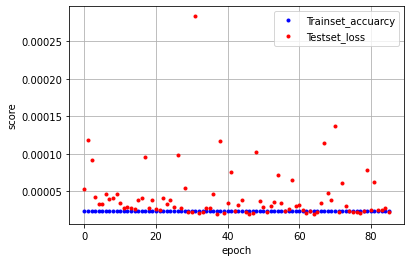

 Accuracy: 0.0010


In [108]:
y_vloss = hist.history['val_loss']   # 테스트셋 오차
#print(len(y_vloss))   # shape함수는 리스트에 적용안됨

# 학습셋 정확도
y_acc = hist.history['accuracy']

# 테스트셋 정확도
y_val_accuracy = hist.history['val_accuracy']
x_len = np.arange(len(y_acc))

#학습셋 정확도 라인
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label = 'Trainset_accuarcy')

#테스트셋 오차 라인
plt.plot(x_len, y_vloss, 'o', c='red', markersize=3, label = 'Testset_loss')

plt.legend(loc='best')   #location  right, left, upper rigtht 등등 
plt.grid()   # 격자 
plt.xlabel('epoch')
plt.ylabel('score')

plt.show()

# 테스트 정확도 출력
print(' Accuracy: %.4f' % y_val_accuracy[-1])  
#제일 마지막 정확도를 가져오고 싶어서 인덱싱 -1번 

In [88]:
train_sc_df.describe()

,WL,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
count,54585.000000,54584.000000,54583.000000,54582.000000,54581.000000,54580.000000,54579.000000,54578.000000,54577.000000,54576.000000,54575.000000,54574.000000,54573.000000
mean,0.131481,0.131476,0.131472,0.131467,0.131463,0.131458,0.131453,0.131449,0.131444,0.131440,0.131435,0.131430,0.131426
std,0.097404,0.097399,0.097394,0.097388,0.097383,0.097378,0.097373,0.097368,0.097363,0.097358,0.097353,0.097348,0.097343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758,0.061758
50%,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140
75%,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145,0.159145
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
test_sc_df.describe()

,WL,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
count,56586.000000,56585.000000,56584.000000,56583.000000,56582.000000,56581.000000,56580.000000,56579.000000,56578.000000,56577.000000,56576.000000,56575.000000,56574.000000
mean,0.199371,0.199369,0.199367,0.199366,0.199364,0.199362,0.199361,0.199359,0.199358,0.199356,0.199354,0.199353,0.199351
std,0.147557,0.147558,0.147559,0.147560,0.147561,0.147561,0.147562,0.147563,0.147564,0.147565,0.147565,0.147566,0.147567
min,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010,-0.076010
25%,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382,0.059382
50%,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140,0.121140
75%,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544,0.351544
max,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007,1.057007


In [109]:
# evaluate 메소드 활용: compile에서 사용했던 metric, mse값 확인
score = model.evaluate(X_test_t, y_test, batch_size=20)
print(score)

546/546 [==============================] - 1s 2ms/step - loss: 4.7073e-05 - mean_squared_error: 4.7073e-05
[4.707257539848797e-05, 4.707257539848797e-05]


Text(0.5, 1.0, 'WL vs Predicted WL Index: $Y_i$ vs $\\hat{Y}_i$')

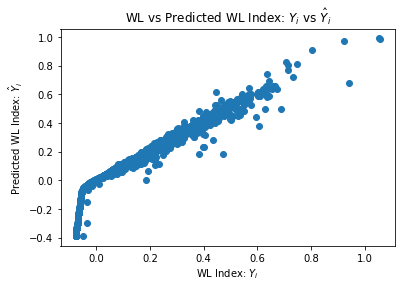

In [110]:
# 예측 결과 시각화하여 확인
%matplotlib inline
import matplotlib.pyplot as plt

# 원래 값과 예측 값이 일치하면 직선에 가깝게 분포가 되는데 결과가 나쁘지 않다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("WL Index: $Y_i$")
plt.ylabel("Predicted WL Index: $\hat{Y}_i$")
plt.title("WL vs Predicted WL Index: $Y_i$ vs $\hat{Y}_i$")

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_te

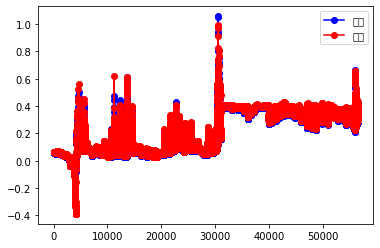

In [111]:
# test 값과 예측 값 시각화
plt.plot(y_test, 'bo-', label='실제')
plt.plot(y_pred, 'ro-', label='예측')
plt.legend()